In [1]:
### Check python versions
!which python
!python --version

/home/thomas/workspace/ml_template/.venv/bin/python
Python 3.8.14
['/home/thomas/workspace/ml_template/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/thomas/workspace/ml_template/.venv/lib/python3.8/site-packages', '/home/thomas/workspace/ml_template/src', '/home/thomas/workspace/ml_template/']


In [2]:
# System libraries
import os.path
from pathlib import Path
from urllib.parse import urlparse

# Import DS librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import mlflow

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.saved_model import signature_constants

# Import Vision librairies
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

2022-09-15 17:39:04.186979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 17:39:04.187020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
dataset = "../../data/sea_animals"
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

image_df.head()

,Filepath,Label
0,../../data/sea_animals/Corals/4306503079_a3803...,Corals
1,../../data/sea_animals/Corals/29588052888_09f2...,Corals
2,../../data/sea_animals/Corals/4562957248_f41db...,Corals
3,../../data/sea_animals/Corals/8333266856_3e518...,Corals
4,../../data/sea_animals/Corals/4391260135_0fe69...,Corals


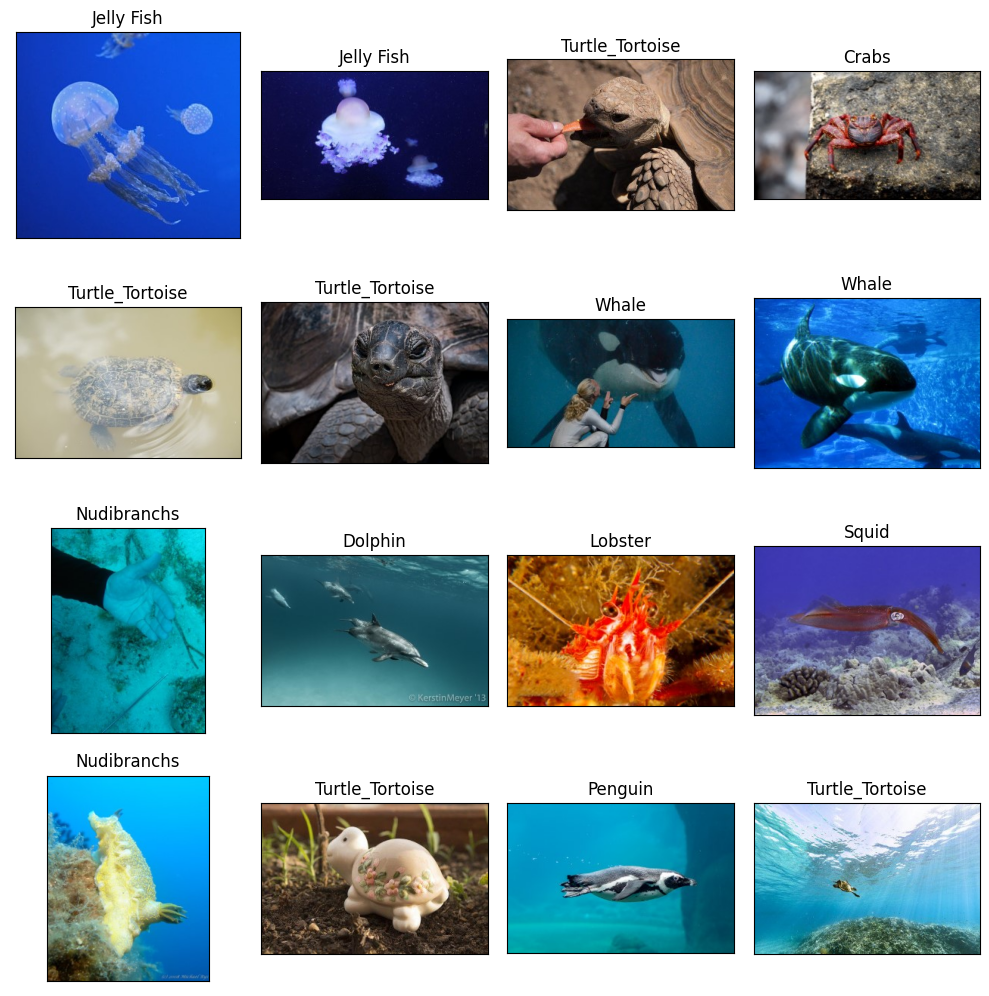

In [5]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
def split(image_df, batch_size):

    # Separate in train and test data
    train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

    train_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
        validation_split=0.2
    )

    test_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
    )

    # Split the data into three categories.
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        subset='training'
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        subset='validation'
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )

    return train_images, val_images, test_images

In [7]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

2022-09-15 17:39:08.779700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-15 17:39:08.779833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 17:39:08.779892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-15 17:39:08.779933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-15 17:39:08.779970: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [8]:
# Create checkpoint callback
checkpoint_path = "sea_animal_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training


mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("sea_animals_classification")
with mlflow.start_run(run_name="Experiment 1"):

    ### hyperparams
    denses = [256,256,19]
    dropout = [0.2, 0.2]
    adam_param = 0.00001
    batch_size = 4
    
    ### Data Generators
    train_images, val_images, test_images = split(image_df, 4)
    
    ### Model
    inputs = pretrained_model.input
    x = resize_and_rescale(inputs)
    x = Dense(denses[0], activation='relu')(pretrained_model.output)
    x = Dropout(dropout[0])(x)
    x = Dense(denses[1], activation='relu')(x)
    x = Dropout(dropout[1])(x)
    outputs = Dense(denses[2], activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    ### Mlflow logging params
    mlflow.log_param("adam", adam_param)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("nb_dense", denses)
    mlflow.log_param("batch_size", batch_size)
    print("Training parameters logged to tracking server.")

    model.compile(
        optimizer=Adam(adam_param),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=2,
        callbacks=[
            early_stopping,
            checkpoint_callback,
        ]
    )

    ### Evaluate model
    results = model.evaluate(test_images, verbose=1)

    mlflow.log_metric("train_loss", history.history['loss'][0])
    mlflow.log_metric("train_accuracy", history.history['accuracy'][0]*100)
    mlflow.log_metric("val_loss", history.history['loss'][1])
    mlflow.log_metric("val_accuracy", history.history['accuracy'][1]*100)
    mlflow.log_metric("test_loss", results[0])
    mlflow.log_metric("test_accuracy", results[1]*100)
    print("Metrics logged to tracking server.")

    tf.keras.models.save_model(model, "./model")
    print("Model saved locally")

    mlflow.log_artifacts("./model")
    print("Model artifact logged.")

    if mlflow.get_tracking_uri() != 'http://localhost:5000':
        try:
            tag=[tf.compat.v1.saved_model.tag_constants.SERVING]
            key=signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY
            mlflow.tensorflow.log_model(tf_saved_model_dir="./model",
                                    tf_meta_graph_tags=tag,
                                    tf_signature_def_key=key,
                                    artifact_path="model",
                                    registered_model_name="MobileNetV2")
            print("Model sent to registry.")
        except Exception as e:
            print("Impossible to log model to registry: {}".format(e))
    else:
        print("No mlflow repository found. Not saving model to it.")
    

2022/09/15 17:39:09 INFO mlflow.tracking.fluent: Experiment with name 'sea_animals_classification' does not exist. Creating a new experiment.


Found 7515 validated image filenames belonging to 19 classes.
Found 1878 validated image filenames belonging to 19 classes.
Found 2349 validated image filenames belonging to 19 classes.
Training parameters logged to tracking server.
Epoch 1/2


2022-09-15 17:39:09.787392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1879/1879 [==============================] - 92s 48ms/step - loss: 2.8384 - accuracy: 0.1606 - val_loss: 2.5831 - val_accuracy: 0.2242
Epoch 2/2
1879/1879 [==============================] - 96s 51ms/step - loss: 2.5620 - accuracy: 0.2315 - val_loss: 2.4335 - val_accuracy: 0.2455
Test results:
588/588 [==============================] - 25s 42ms/step - loss: 2.4229 - accuracy: 0.2576
Metrics logged to tracking server.


2022-09-15 17:42:48.030724: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model/assets


/home/thomas/workspace/ml_template/.venv/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model saved locally
Model artifact logged.
Not mlflow repository found. Not saving model to it.
